In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
from tqdm.notebook import tqdm

def allsymbols(path):
    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    allsymbol=[]
    symbols=mt5.symbols_get()
    count=0
    for s in symbols:
        count+=1
        allsymbol.append(s.name)
    return allsymbol

def readdata(market,tf,barre,path):
    from datetime import datetime
    import MetaTrader5 as mt5
    import pandas as pd

    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    
    mk=str(market)
    TF="mt5.TIMEFRAME_"+str(tf)
    bar=barre
     
    while True:

        try:
            rates = mt5.copy_rates_from_pos(mk, eval(TF), 0, bar) #1700
            if len(rates)>0:
                break
        except:
            continue

    rates_frame = pd.DataFrame(rates)
    rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame=rates_frame[["time","open","high","low","close","tick_volume"]]
    rates_frame.columns=(["time","open","high","low","close","volume"])
    rates_frame=rates_frame.set_index(["time"])
    rates_frame=rates_frame[(rates_frame.T != 0).any()]
    return rates_frame

def get_poin_values(path,simb):

    import MetaTrader5 as mt5
    # establish connection to the MetaTrader 5 terminal
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()

    # display EURJPY symbol properties
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    # shut down connection to the MetaTrader 5 terminal
    mt5.shutdown()
    tmp=int(symbol_info_dict["trade_tick_value"]*symbol_info_dict["trade_contract_size"])
    if "JPY" in simb:
        tmp=int(tmp/100)
    return tmp

def ordine_market(mercato,quantita,deviazione,path,direzione,commento):
    import time
    import pymt5adapter as mta
    from pymt5adapter.order import  Order
    
    mta.initialize(path)
    status=0
    if direzione == "long":
    
        order = Order.as_buy(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    
    if direzione == "short":
    
        order = Order.as_sell(symbol=mercato , 
                              volume=float(quantita),
                              #magic=int(magic),
                              type_filling=1,
                              #tp=float(target),
                              #sl=float(stop),
                              deviation=deviazione,
                              comment=commento)
    while True: 
        r = order.send()
        time.sleep(1)
        if r[7]=='Request executed':
            print(r,'Request executed')
            status=1
            break
        if r[7]=="Market closed":
            print(r[7],"Market closed")
            status=0
            break
    return status

def consec_win(dataframe):
    return dataframe.ge(0).groupby(dataframe.ge(0).diff().ne(0).cumsum()).cumsum().shift().max()
def consec_loss(dataframe):
    return dataframe.lt(0).groupby(dataframe.lt(0).diff().ne(0).cumsum()).cumsum().shift().max()
def consec_loss_mean(dataframe):
    return dataframe.lt(0).groupby(dataframe.lt(0).diff().ne(0).cumsum()).cumsum().shift().mean()
def consec_win_mean(dataframe):
    return dataframe.ge(0).groupby(dataframe.ge(0).diff().ne(0).cumsum()).cumsum().shift().mean()

def get_poin_values(path,simb):

    import MetaTrader5 as mt5
    if not mt5.initialize(path):
        print("initialize() failed, error code =",mt5.last_error())
        quit()
    symbol_info=mt5.symbol_info(simb)
    if symbol_info!=None:
        symbol_info_dict = mt5.symbol_info(simb)._asdict()
    mt5.shutdown()    
    tmp=symbol_info_dict['trade_tick_value']/symbol_info_dict['point']
    return tmp

In [2]:
path=(r"C:\Program Files\AMP Global (USA) MT5 Exchange-Traded Futures Only 2\terminal64.exe")

ls_mercati=["AUDCAD","AUDCHF","AUDJPY","AUDNZD","AUDUSD","CADCHF","CADJPY","CHFJPY","EURAUD","EURCAD","EURCHF","EURGBP","EURJPY",\
            "EURNZD","EURUSD","GBPAUD","GBPCAD","GBPCHF","GBPJPY","GBPNZD","GBPUSD","NZDCAD","NZDCHF","NZDJPY","NZDUSD","USDCAD",\
            "USDCHF","USDJPY"]


In [3]:
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

In [22]:

simbolo = "EURCHF"

bpv=get_poin_values(path,simbolo)
x=readdata(simbolo,"H1",80000,path)
x=x[(x.index.hour>2) & (x.index.hour<22)]
                   

#x.index = x.index.tz_localize('UTC').tz_convert('Etc/GMT+1') 
#x = x.resample("B").agg({'open': 'first','high': 'max','low':'min','close':'last','volume':'sum'})
x=x[x.index.dayofweek<5]
x=x.dropna()


dataset=x.loc["2012-01-01":].copy()
#dataset["pnl"] = (dataset.close-dataset.open)*bpv
#dataset["hour"] = dataset.index.hour
data = dataset.copy()
dataset.head(20)

,open,high,low,close,volume
time,,,,,
2012-01-02 03:00:00,1.21490,1.21541,1.21427,1.21483,705
2012-01-02 04:00:00,1.21482,1.21637,1.21445,1.21596,883
2012-01-02 05:00:00,1.21592,1.21607,1.21541,1.21575,683
2012-01-02 06:00:00,1.21584,1.21616,1.21489,1.21580,705
2012-01-02 07:00:00,1.21615,1.21662,1.21537,1.21578,967
2012-01-02 08:00:00,1.21567,1.21667,1.21337,1.21403,1810
2012-01-02 09:00:00,1.21400,1.21575,1.21366,1.21525,1768
2012-01-02 10:00:00,1.21513,1.21725,1.21493,1.21709,2049
2012-01-02 11:00:00,1.21706,1.21750,1.21627,1.21674,1785


In [49]:
pnl = ((dataset.close-dataset.open)*bpv).to_frame("PNL")
#pnl["M"] = pnl.index.minute
pnl["H"] = pnl.index.hour
pnl["D"] = pnl.index.dayofweek
#pnl["M"] = pnl.index.month
#pnl["Y"] = pnl.index.year
#pnl["V"] = dataset.volume
#pnl["DY"] = pnl.index.day
#pnl["Q"] = pnl.index.quarter
#pnl["W"] = pnl.index.week
#pnl["DOY"] = pnl.index.dayofyear
#df = pnl.groupby(["H","D","M"]).sum().PNL.to_frame()#.plot.bar(figsize=(20,10))
#df

In [20]:
dataset_perc = dataset.apply(lambda x: np.log(x)).pct_change()

LPERC = 0.01
HPERC = 0.99

for column in dataset_perc.columns:
    lower_perc = dataset_perc[column].quantile(LPERC)
    higher_perc = dataset_perc[column].quantile(HPERC)
    print(column,lower_perc,higher_perc)
    dataset_perc[column] = dataset_perc[column].clip(lower_perc,higher_perc)

dataset_perc["avgclose5"] = dataset_perc.close.rolling(5).mean()
dataset_perc["avgclose20"] = dataset_perc.close.rolling(20).mean()
dataset_perc["avgclose50"] = dataset_perc.close.rolling(50).mean()
dataset_perc["avgclose100"] = dataset_perc.close.rolling(100).mean()
dataset_perc["avgclose200"] = dataset_perc.close.rolling(200).mean()

dataset_perc["stdclose5"] = dataset_perc.close.rolling(5).std()
dataset_perc["stdclose20"] = dataset_perc.close.rolling(20).std()
dataset_perc["stdclose50"] = dataset_perc.close.rolling(50).std()
dataset_perc["stdclose100"] = dataset_perc.close.rolling(100).std()
dataset_perc["stdclose200"] = dataset_perc.close.rolling(200).std()

dataset_perc["max5"] = dataset_perc.high.rolling(5).max()
dataset_perc["max20"] = dataset_perc.high.rolling(20).max()
dataset_perc["max50"] = dataset_perc.high.rolling(50).max()
dataset_perc["max100"] = dataset_perc.high.rolling(100).max()
dataset_perc["max200"] = dataset_perc.high.rolling(200).max()

dataset_perc["min5"] = dataset_perc.low.rolling(5).min()
dataset_perc["min20"] = dataset_perc.low.rolling(20).min()
dataset_perc["min50"] = dataset_perc.low.rolling(50).min()
dataset_perc["min100"] = dataset_perc.low.rolling(100).min()
dataset_perc["min200"] = dataset_perc.low.rolling(200).min()

#dataset_perc["H"] = dataset_perc.index.hour
#dataset_perc["D"] = dataset_perc.index.dayofweek

dataset_perc.dropna(inplace = True)

dataset_perc.head()

open -0.08809443495134128 0.09674735699729371
high -0.08201017040858005 0.08135863265831397
low -0.07895029016508681 0.08123845030525448
close -0.08954137182581762 0.09477647032101094
volume -0.11296316107450267 0.15775189937833067


,open,high,low,close,volume,avgclose5,avgclose20,avgclose50,avgclose100,avgclose200,...,max5,max20,max50,max100,max200,min5,min20,min50,min100,min200
time,,,,,,,,,,,,,,,,,,,,,
2012-01-16 13:00:00,0.000392,-0.001737,0.000305,0.000479,-0.040119,0.001146,-0.000137,-0.000286,-0.000256,-0.000118,...,0.002441,0.003728,0.00546,0.007388,0.012966,-0.001844,-0.008674,-0.008674,-0.012065,-0.012065
2012-01-16 14:00:00,0.000523,0.000087,-0.001788,-0.001002,0.025469,0.000621,-0.000198,-0.000296,-0.000256,-0.000147,...,0.002441,0.003728,0.00546,0.007388,0.012966,-0.001788,-0.008674,-0.008674,-0.012065,-0.012065
2012-01-16 15:00:00,-0.001089,-0.001871,-0.002666,-0.003576,-0.001712,-0.000540,-0.000398,-0.000375,-0.000320,-0.000160,...,0.002441,0.003728,0.00546,0.007388,0.012966,-0.002666,-0.008674,-0.008674,-0.012065,-0.012065
2012-01-16 16:00:00,-0.003358,-0.002006,0.000263,0.001051,-0.030542,-0.000505,-0.000270,-0.000329,-0.000294,-0.000156,...,0.001348,0.003728,0.00546,0.007388,0.012966,-0.002666,-0.008674,-0.008674,-0.012065,-0.012065
2012-01-16 17:00:00,0.001007,0.003582,0.001577,0.002754,0.037168,-0.000059,-0.000165,-0.000203,-0.000257,-0.000142,...,0.003582,0.003728,0.00546,0.007388,0.012966,-0.002666,-0.008674,-0.008674,-0.012065,-0.012065


In [21]:
pnl = pnl[pnl.index.isin(dataset_perc.index)]

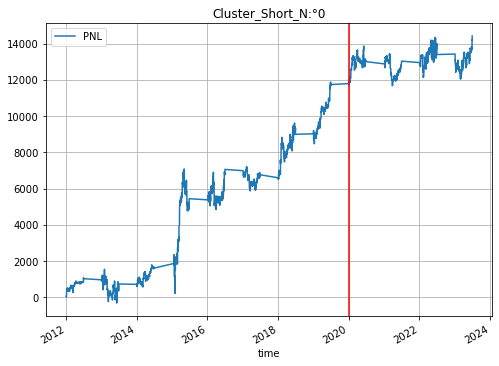

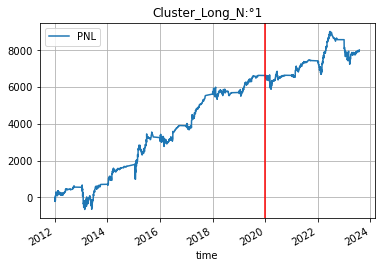

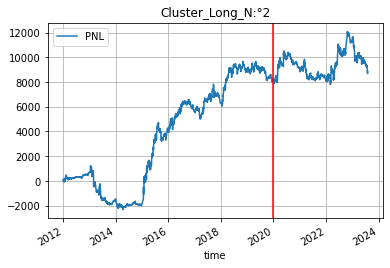

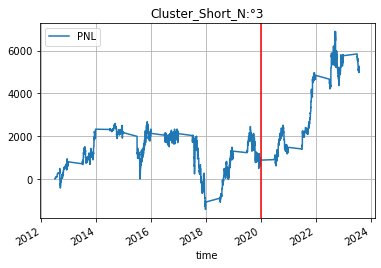

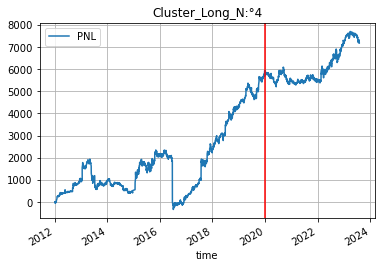

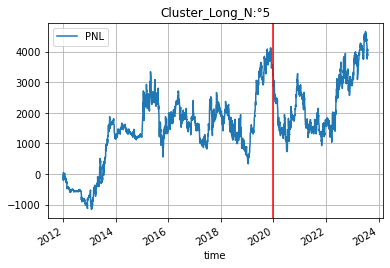

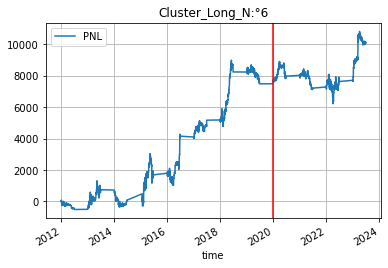

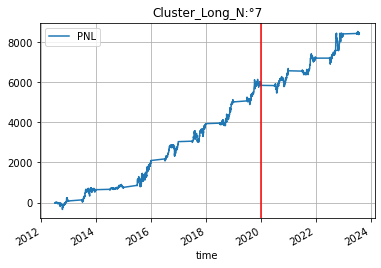

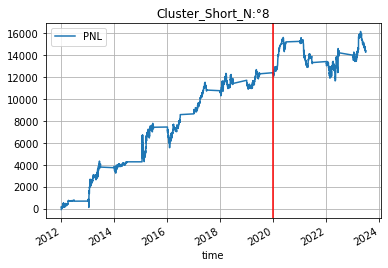

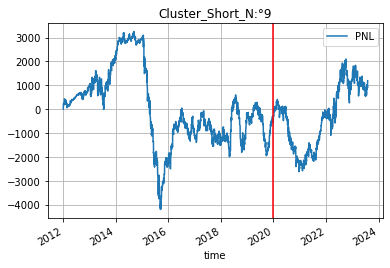

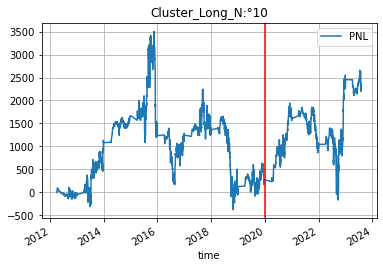

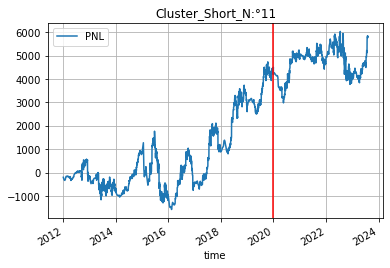

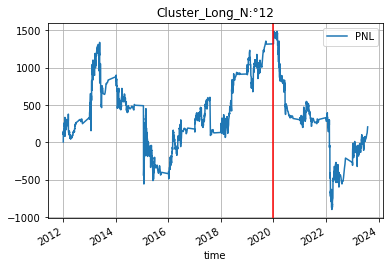

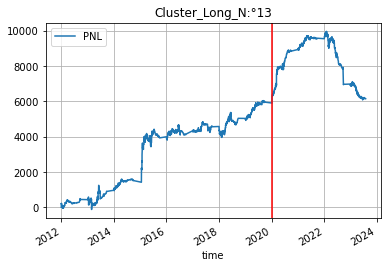

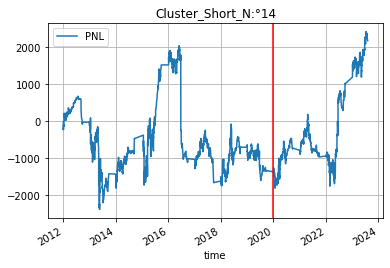

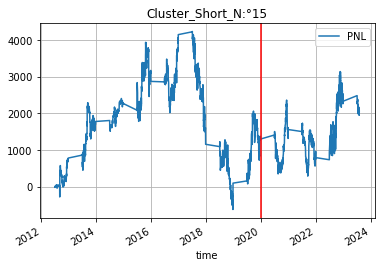

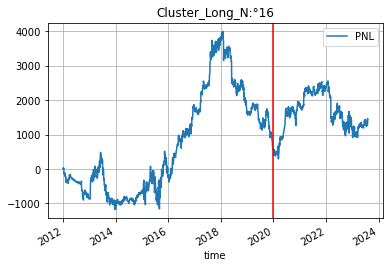

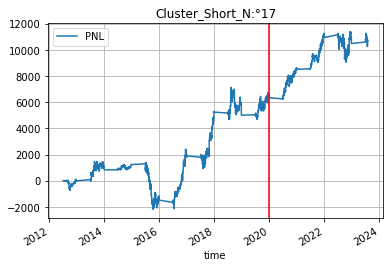

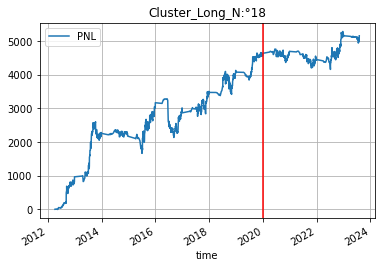

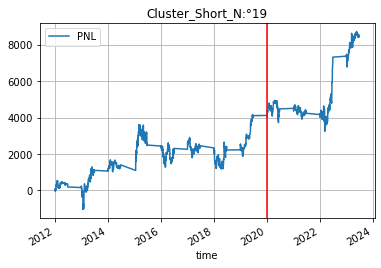

In [50]:
from sklearn.cluster import KMeans

test = pd.DataFrame()
OOS="2020-01-01"
# Supponiamo di avere già creato il dataframe 'X' contenente i dati di addestramento, e 'pnl' contenente i dati completi
X = pnl.iloc[:,1:].loc[:OOS].copy()
#X = dataset_perc.loc[:OOS].copy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#X = scaler.fit_transform(X)


n_clusters = 20

# Creazione e addestramento del modello K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=11)#,n_init=100)
kmeans.fit(X)


# Ora supponiamo di avere nuovi dati in un dataframe chiamato 'new_data'
# Esegui il clustering su nuovi dati
X = pnl.iloc[:,1:].copy()
#X = dataset_perc.copy()
#X = scaler.fit_transform(X)
profit_loss_df = pnl.copy()
new_data_cluster_labels = kmeans.predict(X)

# Ora 'new_data_cluster_labels' conterrà le etichette dei cluster assegnate ai nuovi dati.
profit_loss_df['Cluster'] = new_data_cluster_labels
#profit_loss_df['Cluster'] = profit_loss_df['Cluster'] .shift(1,fill_value=0)
# Visualizzazione dei cluster ottenuti
plt.figure(figsize=(8, 6))
for cluster_id in range(n_clusters):
    cluster_data = profit_loss_df[profit_loss_df['Cluster'] == cluster_id]
    if cluster_data.PNL.loc[:].sum()>0:
        cluster_data.PNL.cumsum().plot(title="Cluster_Long_N:°"+str(cluster_id))
        test = pd.concat([test,cluster_data.PNL.to_frame("Cluster_"+str(cluster_id))])
    else:
        (-cluster_data.PNL).cumsum().plot(title="Cluster_Short_N:°"+str(cluster_id))
        test = pd.concat([test,(-cluster_data.PNL).to_frame("Cluster_"+str(cluster_id))])
    plt.axvline(x=OOS,color="red")
    plt.legend()
    plt.grid(True)
    plt.show()

In [52]:
a=test["Cluster_7"].copy()
a=a[a!=0].dropna()
a=a.to_frame("pnl")
a["H"]=a.index.hour
a["D"]=a.index.dayofweek
a["M"]=a.index.quarter

<AxesSubplot:xlabel='H'>

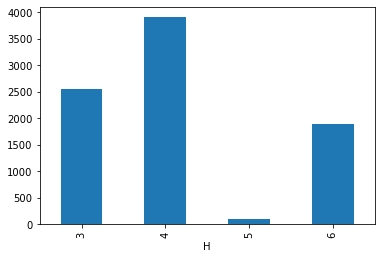

In [53]:
a.groupby("H").sum().pnl.plot.bar()

<AxesSubplot:xlabel='D'>

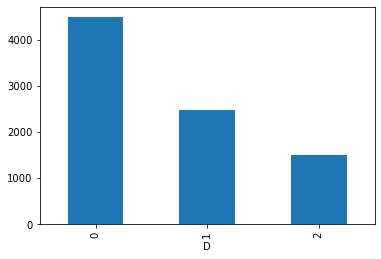

In [54]:
a.groupby("D").sum().pnl.plot.bar()

<AxesSubplot:xlabel='M'>

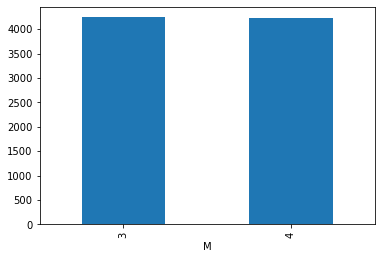

In [55]:
a.groupby("M").sum().pnl.plot.bar()

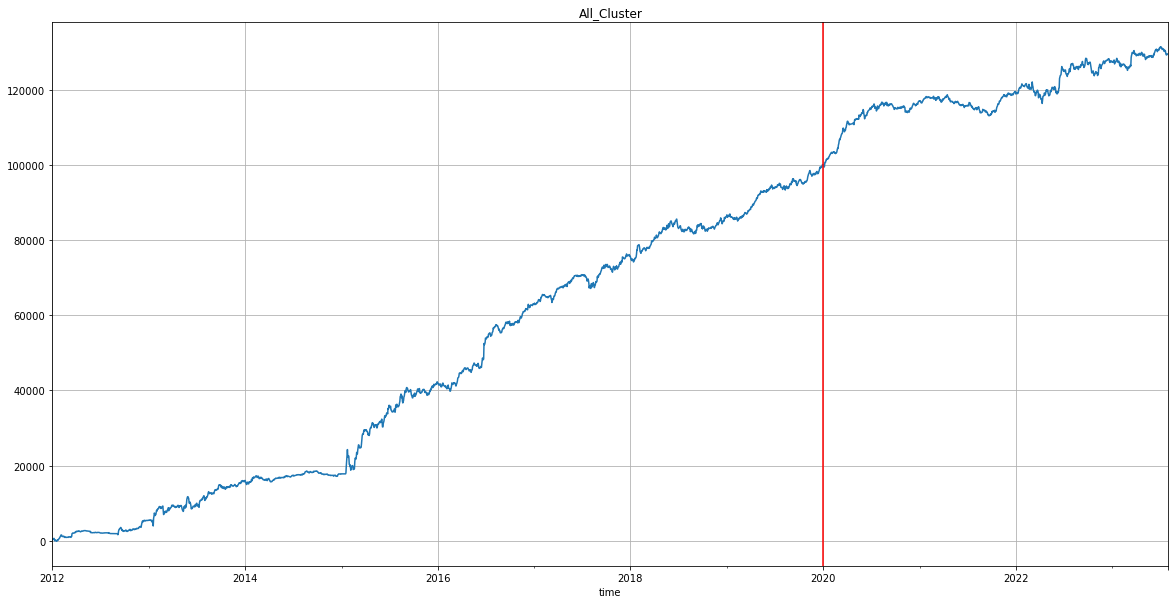

In [44]:
test=test.resample("B").sum()
test.cumsum().sum(axis=1).plot(title="All_Cluster",figsize=(20,10),grid=True)
#dataset.close.plot(secondary_y=True)
plt.axvline(x=OOS,color="red")
plt.show()

In [27]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px

def kestner_ratio_mod(operations):
    
    """Funzione modificata senza resample dei dati"""

    import numpy as np
    import matplotlib.pyplot as plt 
    from scipy import stats
    
    equity = operations.cumsum()
    index = np.array(np.arange(1,equity.count() + 1))
    
    x = index
    y = equity
    gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    
    if std_err != 0 and len(index) > 0:
        return round(gradient / (std_err * len(index)),5)
    else:
        return np.inf

def Agg_Prt_Kestner_Ratio(n_strategy,stampa,dataframe_insample,dataframe_equity):
    
    from itertools import groupby
    from IPython.display import clear_output
    
    newdf=dataframe_insample    
    best_ks=[]
    for g in tqdm(range(len(newdf.columns))):
        x=newdf.iloc[:,g].loc[:OOS]
        y=kestner_ratio_mod(x)
        best_ks.append(y)
    best_strategy=best_ks.index(max(best_ks))
    ls_ok=[]
    ls_ok=[newdf.iloc[:,best_strategy].name]
    ls_col=newdf.columns.to_list()
    ls_col.remove(newdf.iloc[:,best_strategy].name)
    id_ok=[]
    big_ls=[]
    stampa=stampa
    max_strategy=n_strategy
    while True:
        x=newdf[ls_ok].sum(axis=1)
        ls=[]
        if stampa ==1:
            clear_output(wait=True)
            x.cumsum().plot(figsize=(20,10),title="Run N°:"+str(len(ls_ok)))
            plt.show()
        for f in ls_col:
            y=newdf[f]
            k=pd.concat([x,y],axis=1)
            k=k.sum(axis=1)
            #k=k.where(k!=0).dropna()
            j=kestner_ratio_mod(k)
            if j != np.nan:
                ls.append(j)
        ok=ls.index(max(ls))
        ls_ok.append(ls_col[ok])
        big_ls.append(list(set(ls_ok)))
        id_ok.append(max(ls))
        ls_col.remove(ls_col[ok]) ##### modifica 2023
        if len(ls_ok)> max_strategy-1:
            test=pd.DataFrame(ls_ok)
            test.columns=(["val"])
            test["cnt"]=1
            df_mm=test.groupby(by=["val"]).sum()
            df_mm.plot.bar(figsize=(10,10))
            plt.show()
            dataframe_equity[ls_ok].cumsum().plot(figsize=(20,10))
            plt.show()
            dataframe_equity[ls_ok].sum(axis=1).cumsum().plot(figsize=(20,10))
            plt.axvline(OOS, color="red", linestyle="--",label="OutOfSample")
            plt.show()
            break
    return df_mm


def Agg_Prt_MinVar_DD(n_strategy,stampa,dataframe_drawdown,dataframe_equity):

    from itertools import groupby
    from IPython.display import clear_output
    np_sys=dataframe_drawdown.T.values    
    min_var=[]
    for g in tqdm(range(len(np_sys))):
        x=np_sys[g]
        y=x.var()
        min_var.append(y)
    best_strategy=min_var.index(min(min_var))
    ls_ok=[]
    ls_ok=[best_strategy]
    ls_col=newdf.columns.to_list()
    id_ok=[]
    big_ls=[]
    stampa=stampa
    min_strategy=n_strategy
    while True:
        x=sum(np_sys[ls_ok])        
        ls=[]
        if stampa ==1:
            clear_output(wait=True)
            dataframe_drawdown.iloc[:,ls_ok].sum(axis=1).plot(figsize=(20,10),title="Run N°:"+str(len(ls_ok)+1))
            plt.show()
        for f in range(len(np_sys)):
            y=np_sys[f]
            k=x+y
            j=k.var()
            if (j != np.nan)|(j != np.inf):
                ls.append(round((j),5))
        ls_clean=[]
        for e in ls:
            if e == np.inf:
                ls_clean.append(0)
            else:
                ls_clean.append(e)
        min_v=min(ls_clean)
        ok=ls.index(min_v)
        ls_ok.append(ok)    
        big_ls.append(list(set(ls_ok)))
        id_ok.append(min_v)
        if (len(ls_ok)>=min_strategy):
            test=pd.DataFrame(ls_ok)
            test.columns=(["val"])
            test["cnt"]=1
            df_mm=test.groupby(by=["val"]).sum()
            relative_name=list(set(dataframe_equity.iloc[:,ls_ok].columns.to_list()))
            df_mm.index=relative_name
            df_mm.plot.bar(figsize=(10,10))
            plt.show()
            dataframe_equity.iloc[:,ls_ok].cumsum().plot(figsize=(20,10))
            plt.show()
            dataframe_equity.iloc[:,ls_ok].sum(axis=1).cumsum().plot(figsize=(20,10))
            plt.axvline(OOS, color="red", linestyle="--",label="OutOfSample")
            plt.show()
            drawdown(dataframe_equity.iloc[:,ls_ok].sum(axis=1).cumsum()).plot(figsize=(20,5))
            break
    return df_mm

In [28]:
df2=test.copy()
df3 = df2.std().to_frame("STD")
df3["STD_MAX"] = df3.STD.max()
df3["SIZE"] = (df3["STD_MAX"]/df3["STD"]).round(2)
display(df3)
df4=df2.copy()
for i in df3.index.to_list():
    df4[i] = df4[i]*df3.SIZE[df3.index==i].values[0]
df4.tail()

,STD,STD_MAX,SIZE
Cluster_0,199.215457,439.377431,2.21
Cluster_1,184.643408,439.377431,2.38
Cluster_2,170.153815,439.377431,2.58
Cluster_3,149.701171,439.377431,2.94
Cluster_4,241.476512,439.377431,1.82
Cluster_5,237.881157,439.377431,1.85
Cluster_6,186.754556,439.377431,2.35
Cluster_7,279.975590,439.377431,1.57
Cluster_8,269.411671,439.377431,1.63
Cluster_9,164.276686,439.377431,2.67


,Cluster_0,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19
time,,,,,,,,,,,,,,,,,,,,
2023-07-28,0.0,0.0,0.0,-537.432233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,256.588637,0.0,0.000000,1919.453062,0.000000,0.0,0.0
2023-07-31,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1239.008492,-51.006445,0.000000,0.0,0.0
2023-08-01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-717.704449,0.0,0.000000,281.877722,0.000000,0.0,0.0
2023-08-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1357.316704,0.0,0.000000,230.871277,0.000000,0.0,0.0
2023-08-03,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2319.785236,0.000000,0.0,0.000000,0.000000,152.674626,0.0,0.0


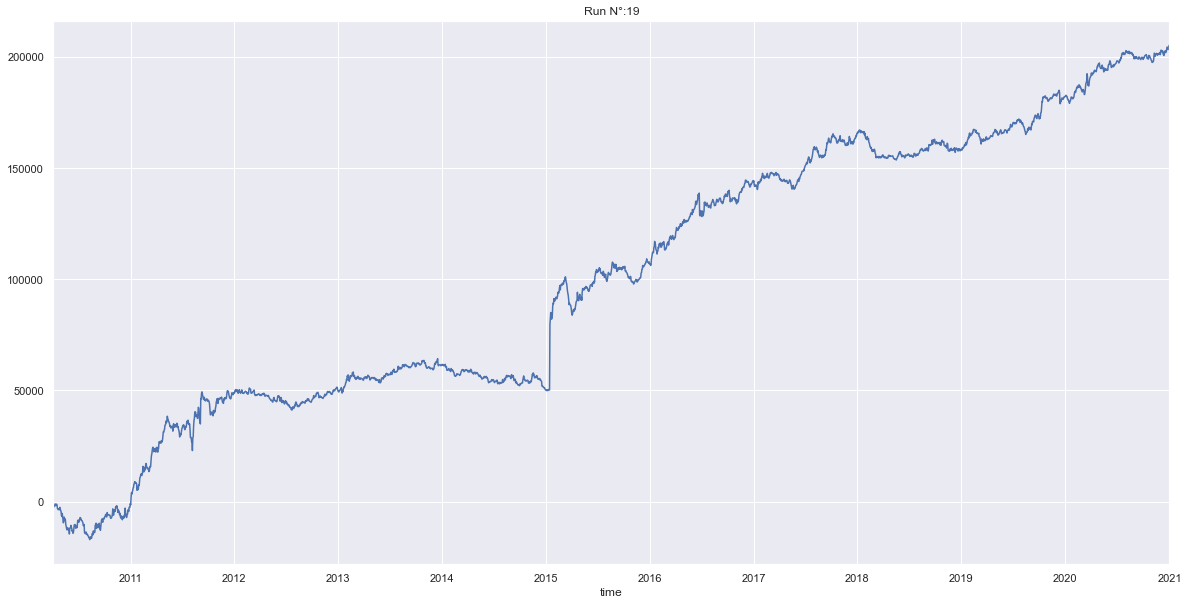

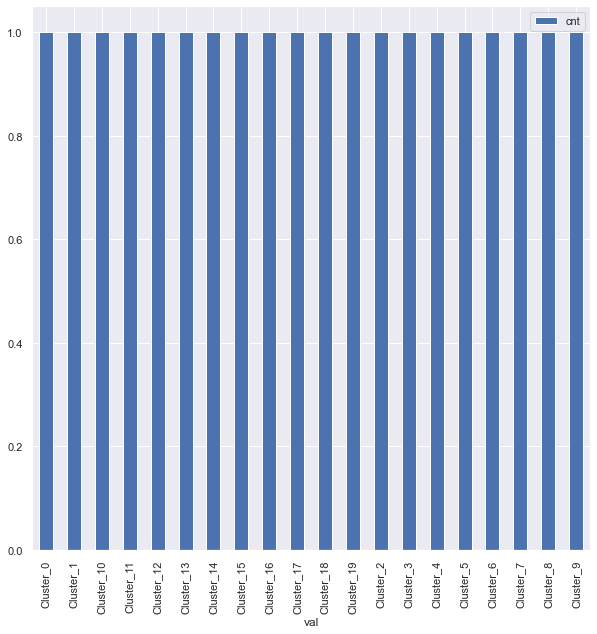

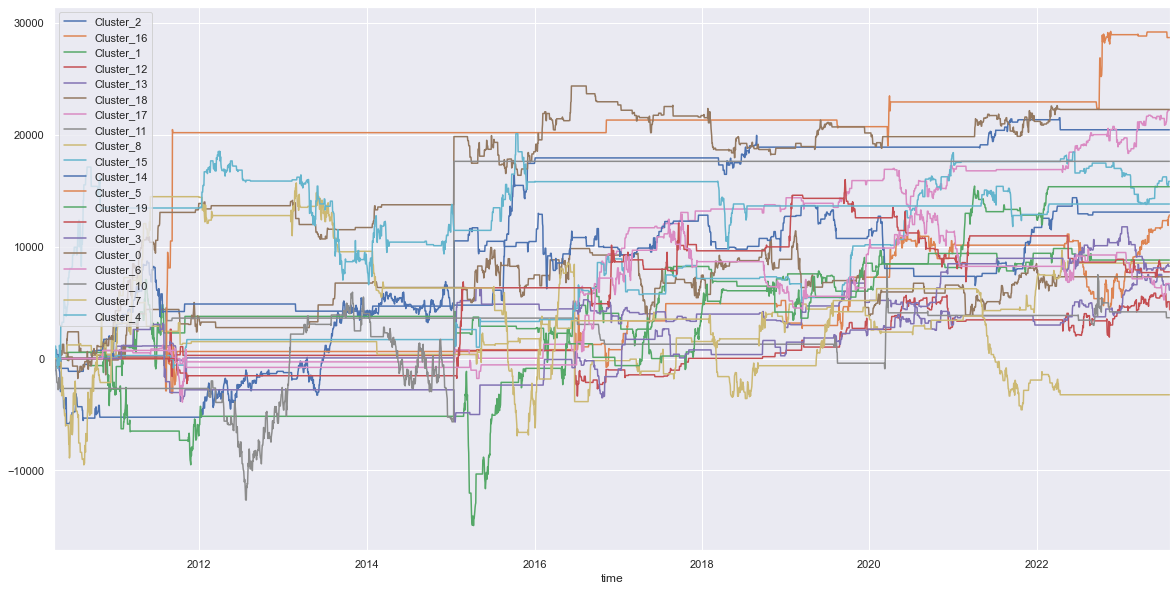

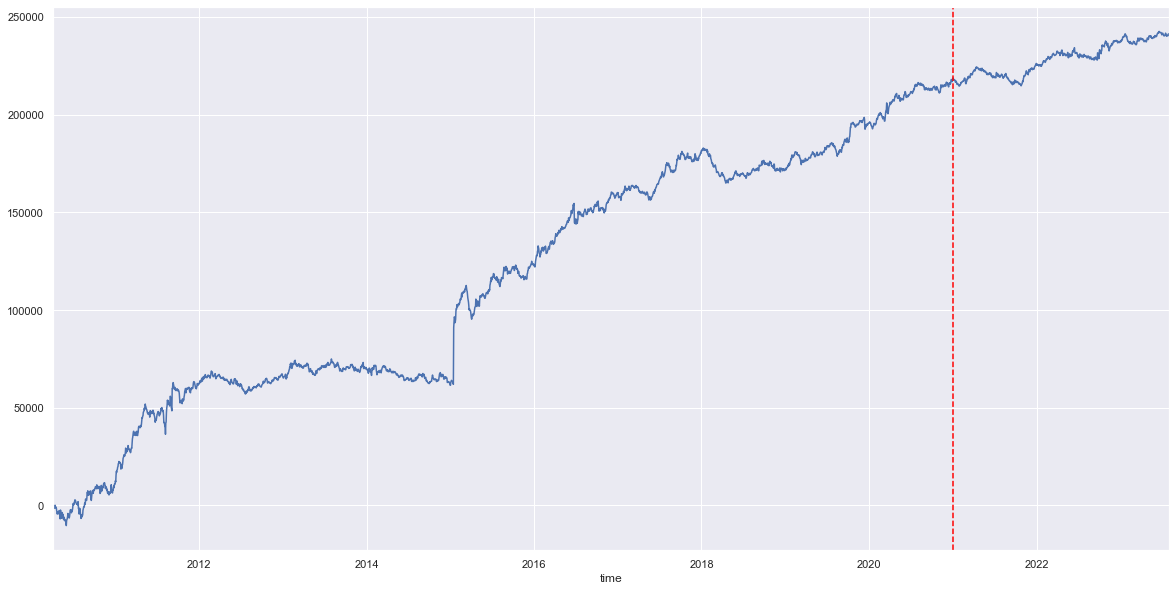

In [29]:
#OOS="2023-05-01"
df4.index=pd.to_datetime(df4.index)
df4=df4.fillna(0)
portafolio_kestner=Agg_Prt_Kestner_Ratio(20,1,df2.loc[:OOS],df2)